In [16]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math
from pennylane.optimize import AdamOptimizer
import sys


In [17]:
# np.random.seed(28)
# np.random.seed(32)
np.random.seed(35)

In [18]:
def random_oracle_builder(num_qubits):
    size = 2**num_qubits
    rand_vec = np.random.rand(size)

    # Generate indices for the zero elements
    num_zeros = np.random.randint(int(size/8),size)
    zero_indices = np.random.choice(size, num_zeros, replace=False)

    # Set the elements at the zero indices to zero
    rand_vec[zero_indices] = 0
    
    # invalid_state = '1'+(num_qubits-1)*'0'
    
    # invalid_state_index = 2**(num_qubits-1)
    # if(rand_vec[invalid_state_index]>0.00001):
    #     print('Oracle has invalid state -0')
    # rand_vec[invalid_state_index]=0
    
    rand_vec = rand_vec/np.linalg.norm(rand_vec)
    return rand_vec

# print(random_oracle_builder(2))

In [19]:
#Global Control Variables
k_helper = None
k_full_global_search_max = None
k_full_global_search_min = None
k_binary_global_search_max = None
k_binary_global_search_min = None

#Thresholds 
threshold_helper_u = 0.25
threshold_helper_l = -0.25
threshold_max = -0.75
threshold_min = 0.75
threshold_min_backtrack = -0.98
threshold_max_backtrack = 0.98
vqs_find_sucess = 0.016 #TODO

#Rates
# global_search_rate_max = 2
# global_search_rate_min = 2



#Devices
device_name_standard_maker = 'default.qubit'
device_global_search = 'default.qubit' 
n_shots=None

# test_input = [0.6, 0.3, 0.0, 0.1, 0.5, 0.0,0.0,0.5,0.5,0.0,0.2,0,0.0,0.1, 0.8, 0.0]
# test_input = np.array(test_input)
# test_input = test_input/np.linalg.norm(test_input)

test_input = random_oracle_builder(num_qubits=6)


num_of_qubits_test = int(np.log2(len(test_input)))
num_overflow_bit = 2
num_qubits = num_of_qubits_test + num_overflow_bit


# start_state = np.array(test_input)
# start_state = start_state/np.linalg.norm(start_state)
start_state = test_input
print(start_state)

[0.         0.11126858 0.         0.         0.29490083 0.
 0.22605114 0.         0.         0.24500798 0.         0.
 0.         0.         0.         0.         0.06707572 0.
 0.27066941 0.08024845 0.         0.         0.         0.
 0.12204945 0.         0.         0.31564524 0.         0.
 0.         0.         0.         0.         0.         0.30027454
 0.         0.         0.         0.08980773 0.         0.
 0.08853885 0.19703375 0.         0.         0.         0.30006719
 0.         0.         0.28941607 0.217851   0.17812743 0.33669339
 0.         0.         0.         0.         0.05590256 0.27645305
 0.         0.         0.         0.        ]


In [20]:
# Calculate global maximum and minimum (classical) for test purposes
cls_max_val = -2**num_of_qubits_test
cls_min_val = 2**num_of_qubits_test


for x in range(len(test_input)):
    bin_rep = np.binary_repr(x,num_of_qubits_test)
    #print(bin_rep,': ',test_input[x])
    if(np.isclose(test_input[x],0)):
        continue

    if(bin_rep[0]=='1'):
        x=int(bin_rep,2)-(1<<num_of_qubits_test)
    if(x<cls_min_val):
        cls_min_val=x
    if(x>cls_max_val):
        cls_max_val=x

print(cls_max_val)
print(cls_min_val)


27
-29


In [21]:
def add_k_sign(k, wires):
    #sign handling
    bin_rep = np.binary_repr(k,len(wires))
    k = int(bin_rep,2)

    qml.QFT(wires=wires)
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])
    qml.adjoint(qml.QFT)(wires=wires)

In [22]:
dev_standard_maker = qml.device(device_name_standard_maker, wires=num_qubits,shots=n_shots) 
@qml.qnode(dev_standard_maker)
def standard_maker_helper_circuit(k,input,wires):
    qml.QubitStateVector(np.array(input), wires=wires[num_overflow_bit:])
     # add some bits for handle overflow
    for w in reversed(range(1,num_overflow_bit+1)):
        qml.CNOT([w,w-1])
    add_k_sign(k,wires=wires)
    return qml.expval(qml.PauliZ(wires=0))


#qml.draw_mpl(standard_maker_helper_circuit, show_all_wires=True)(0,start_state,dev_standard_maker.wires)
#plt.show()

K_helper :  11


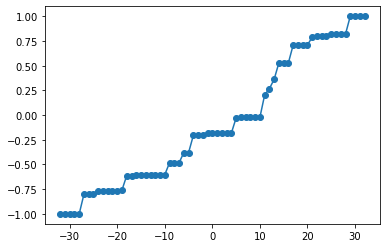

In [23]:

# x=[i for i in range(-2**(num_qubits-1-1),2**(num_qubits-1-1)+1)]
x=[i for i in range(-(2**(num_of_qubits_test-1)),2**(num_of_qubits_test-1)+1)]
y=[]
for i in x:
    exp_val = standard_maker_helper_circuit(i,start_state,dev_standard_maker.wires) 
    # print(i)
    # print(exp_val)
    if(threshold_helper_l<exp_val<threshold_helper_u):
        # print(i)
        k_helper = i

    y.append(exp_val)

# plot scatter plot with x and y data
plt.scatter(x, y)
  
# plot with x and y data
plt.plot(x, y)

if(k_helper==None):
    print('Error in standard making')

print('K_helper : ',k_helper)


In [24]:
k_helper_binary = None
size = 2**(num_qubits-num_overflow_bit)-1

temp_k=0
max_iteration = 2*math.log(size) # 2* ? for seed=40 max_iteration+2 works
iteration = 0
while k_helper_binary == None and iteration <= max_iteration+1:
    exp_val = standard_maker_helper_circuit(temp_k,start_state,dev_standard_maker.wires)
    if(exp_val>threshold_helper_l and exp_val<threshold_helper_u):
        k_helper_binary = temp_k
    else:
        if(exp_val>0):
             temp_k -= int((size-abs(temp_k))/2)-1
        else:
            temp_k += int((size-abs(temp_k))/2)+1
    iteration+=1
k_helper = k_helper_binary

print(k_helper)

if(k_helper==None):
        raise UserWarning('F(x) is near constant. Measure it to find the global optimum !')

            

0


In [25]:
dev_global_search = qml.device(device_global_search, wires=num_qubits,shots=n_shots) 
@qml.qnode(dev_global_search)
def global_search(k_new,k_helper,input,wires):
    qml.QubitStateVector(np.array(input), wires=wires[num_overflow_bit:])
    # add some bits for handle overflow
    for w in reversed(range(1,num_overflow_bit+1)):
        qml.CNOT([w,w-1])     
    add_k_sign(k_helper+k_new,wires=wires)
    return qml.expval(qml.PauliZ(wires=0))

In [26]:
def classical_vqs_result_optimal_finder(vqs_res):
    min_bound = -2**num_of_qubits_test-2
    max_bound = 2**num_of_qubits_test+2
    
    cls_max_val = min_bound
    cls_min_val = max_bound

    #TODO invalid state handling ?
    for x in vqs_res:
        val = x[0]
        if(val<cls_min_val):
            cls_min_val=val
        if(val>cls_max_val):
            cls_max_val=val
    if cls_max_val==min_bound:
        cls_max_val=None
    if cls_min_val==max_bound:
        cls_min_val=None
        
    return {'min':cls_min_val,'max':cls_max_val}


In [27]:
# Binary Search

size = 2**(num_qubits-num_overflow_bit)-1
i_max=0
i_min=0

i_max_previous = i_max
while k_binary_global_search_max==None:
    exp_val = global_search(-i_max,k_helper,start_state,dev_global_search.wires)
    if(exp_val<threshold_max):
        if(exp_val<threshold_max_backtrack):
            k_binary_global_search_max = -i_max_previous
        else:
            k_binary_global_search_max = -i_max
    else:
        i_max_previous = i_max
        i_max += int((size-i_max)/2)+1
    
print('done')
i_min_previous = i_min            
while k_binary_global_search_min==None:
    exp_val = global_search(i_min,k_helper,start_state,dev_global_search.wires) 
    if(exp_val>threshold_min):
        if(exp_val>threshold_min_backtrack):
            k_binary_global_search_min = i_min_previous
        else:
            k_binary_global_search_min = i_min
    else:
        i_min_previous = i_min
        i_min += int((size-i_min)/2)+1




done


In [28]:
# !pip install pennylane
# !pip install pennylane-qiskit
# !pip install pennylane-lightning
# !pip install pennylane-lightning[gpu]  # has erro

import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as qml_np
import pennylane as qml

import math
import matplotlib.pyplot as plt
import datetime

# print(k_helper)
# print(k_full_global_search_min)
#VQS + full search
shift_max = k_helper+k_binary_global_search_max

# global_shift_min = 0

# print(start_state)
# print(num_qubits)
# print(num_overflow_bit)
# print(global_shift_min)

# vqs
num_qubit_vqs = 1+num_qubits
eps_val_q = 1/math.sqrt(2**num_qubit_vqs)/100
eps_val = min(1e-10, eps_val_q)
tiny_change_threshold = 1e-4
cnt_threshold_no_change = 5

print_circuit_flag = False

N = 2**(num_qubit_vqs-2)
normal_val = math.sqrt(1/N)
# initial_state_phi1 = [math.sqrt(1/N)]*(N-1) + [0]*N + [math.sqrt(1/N)] # 2**(num_qubit_vqs-1)
# initial_state_phi1 = [.5,.5,.5, 0,   0, 0, 0, .5,  ] # 2**(num_qubit_vqs-1)

# initial_state2 = [1/math.sqrt(N)]*(N-2) + [0, 1/math.sqrt(N)] + [0]*(N-2) + [1/math.sqrt(N), 0] # 2**(num_qubits-1)
# start_state = np.array([0.6, 0.3, 0.0, 0.1, 0.0, 0.0, 0.5, 0.5])
# start_state = np.array([0.6, 0.3, 0.0, 0.1, 0.0, 0.0,
#                         0.0, 0.2, 0.0, 0.4, 0.3, 0.0, 0.0, 0.5, 0.0, 0.0])
# start_state = start_state/np.linalg.norm(start_state)
initial_state2 = start_state.tolist()

initial_state_phi1 = initial_state2
print(f'initial_state_phi1={initial_state_phi1}')
# print(f'initial_state_phi1={initial_state_phi1[-5:]}')
# initial_state_0_phi1 = initial_state_phi1 + \
#     [0]*len(initial_state_phi1)  # 2**num_qubit_vqs


# print(f'initial_state3={initial_state3}')
# initial_state  = initial_state3 + [0]*len(initial_state3) # 2**num_qubits

# print(np.arange(1, 10, 3))
# print(np.linspace(1, 10, 4))
# print(list(range(10)))

device_name = 'default.qubit'  # 'default.qubit' #
device_name2 = 'default.qubit'  # has qml.state()


def oracle_builder_for_HT_HTZ():
    qml.QubitStateVector(np.array(start_state), wires=range(
        1+num_overflow_bit, num_qubit_vqs))
    
    # add some bits for handle overflow
    for w in reversed(range(2, num_overflow_bit+2)):
        qml.CNOT([w, w-1])
    add_k_sign(shift_max, wires=range(1, num_qubit_vqs))

    

def oracle_builder_for_no_HT_HTZ():
    qml.QubitStateVector(np.array(start_state), wires=range(
       num_overflow_bit, num_qubit_vqs-1))
    # add some bits for handle overflow
    for w in reversed(range(1, num_overflow_bit+1)):
        qml.CNOT([w, w-1])
    add_k_sign(shift_max, wires=range(0, num_qubit_vqs-1))


def layer_t3_no_HT(theta, qubit_posi):
    # type-2 layer
    # length of theta: (num_qubit_vqs-1)*2
    # length of qubit_posi: num_qubit_vqs-1
    # number of wires: num_qubit_vqs
    

    for i in range(num_qubit_vqs-1):
        qml.RY(theta[i], wires=(qubit_posi[i]))
    for i in np.arange(0, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(qubit_posi[i+1]), qubit_posi[i]) # CZ struct2
        qml.CNOT(wires=(qubit_posi[i], qubit_posi[i+1]))  # CNOT struct3
    for i in range(num_qubit_vqs-1):
        qml.RY(theta[i+num_qubit_vqs-1], wires=(qubit_posi[i]))
    for i in np.arange(1, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(qubit_posi[i+1]), qubit_posi[i]) # CZ struct2
        qml.CNOT(wires=(qubit_posi[i], qubit_posi[i+1]))  # CNOT struct3
#     qml.ctrl(qml.PauliZ(qubit_posi[0]), qubit_posi[-1]) # CZ struct2
    qml.CNOT(wires=(qubit_posi[-1], qubit_posi[0]))  # CNOT struct3


def layer_t3_with_HT(theta, num_qubit_vqs):
    # type-2 layer
    # length of theta: (num_qubit_vqs-1)*2
    # number of wires: num_qubit_vqs
    
    
    
    for i in range(num_qubit_vqs-1):
        qml.CRY(theta[i], wires=(0, i+1))
    for i in np.arange(0, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(i+2), (0, i+1)) # CZ struct2
        qml.Toffoli(wires=(0, i+1, i+2))  # CCNOT struct3

    for i in range(num_qubit_vqs-1):
        qml.CRY(theta[i+num_qubit_vqs-1], wires=(0, i+1))
    for i in np.arange(1, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(i+2), (0, i+1)) # CZ struct2
        qml.Toffoli(wires=(0, i+1, i+2))  # CCNOT struct3
#     qml.ctrl(qml.PauliZ(1), (0, num_qubit_vqs-1)) # CZ struct2
    qml.Toffoli(wires=(0, num_qubit_vqs-1, 1))  # CCNOT struct3



# dev_with_HT=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs, shots=20000, backend='qasm_simulator')
dev_with_HT = qml.device(device_name, wires=num_qubit_vqs,shots=n_shots)


@qml.qnode(dev_with_HT)
def quantum_circuit_with_HT(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_0_phi1),
    #                      wires=range(num_qubit_vqs))
#     qubit_position = list(range(1,num_qubit_vqs))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs)

    oracle_builder_for_HT_HTZ()
    qml.PauliX(wires=1) #MAX
    
    qml.Hadamard(0)
    for theta_i in theta:
        layer_t3_with_HT(theta_i, num_qubit_vqs)
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))


    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
if(print_circuit_flag):
    print(qml.draw(quantum_circuit_with_HT)([[0.1]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HT([[0.1]*(num_qubit_vqs-1)]))


# dev_with_HTZ=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs, shots=20000, backend='qasm_simulator')
dev_with_HTZ = qml.device(device_name, wires=num_qubit_vqs,shots=n_shots)


@qml.qnode(dev_with_HTZ)
def quantum_circuit_with_HTZ(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_0_phi1),
    #                      wires=range(num_qubit_vqs))
#     qubit_position = list(range(1,num_qubit_vqs))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs)

    oracle_builder_for_HT_HTZ()
    qml.PauliX(wires=1) #MAX

    qml.Hadamard(0)
    for theta_i in theta:
        layer_t3_with_HT(theta_i, num_qubit_vqs)
    qml.CZ([0, 1])
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))


    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
if(print_circuit_flag):
    print('newly added')
    print(qml.draw(quantum_circuit_with_HTZ)([[0.1]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HTZ([[0.1]*(num_qubit_vqs-1)]))


# dev_no_HT_Z=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs-1, shots=20000, backend='qasm_simulator')
dev_no_HT_Z = qml.device(device_name, wires=num_qubit_vqs-1,shots=n_shots)


@qml.qnode(dev_no_HT_Z)
def quantum_circuit_no_HT_return_Z(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_phi1),
    #                      wires=range(num_qubit_vqs-1))
#     qubit_position = list(range(num_qubit_vqs-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs-1)

    oracle_builder_for_no_HT_HTZ()
    qml.PauliX(wires=0) #MAX

    for theta_i in theta:
        layer_t3_no_HT(theta_i, list(range(num_qubit_vqs-1)))
    
    qml.PauliX(wires=0) #MAX

    return qml.expval(qml.PauliZ(0))

    # return qml.sample(qml.PauliZ(0))
if(print_circuit_flag):
    print('newly added 2')
    print(qml.draw(quantum_circuit_no_HT_return_Z)([[0.2]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HT([[0.2]*(num_qubit_vqs-1)]))


# dev_no_HT_S=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs-1, backend='qasm_simulator')
dev_no_HT_S = qml.device(device_name2, wires=num_qubit_vqs-1,shots=n_shots)


@qml.qnode(dev_no_HT_S)
def quantum_circuit_no_HT_return_state(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_phi1),
    #                      wires=range(num_qubit_vqs-1))
#     qubit_position = list(range(num_qubit_vqs-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs-1)

    oracle_builder_for_no_HT_HTZ()
    qml.PauliX(wires=0) #MAX
    
    for theta_i in theta:
        layer_t3_no_HT(theta_i, list(range(num_qubit_vqs-1)))
    qml.PauliX(wires=0) #MAX    
        
    return qml.state()


if(print_circuit_flag):
    print('newly added 3')


val_global = []
coef2 = 1


def objective_fn(theta):
    global val_global
    val1_1 = quantum_circuit_with_HT(theta)
    val1_2 = quantum_circuit_with_HTZ(theta)
    val1_1 = val1_1/normal_val
    val1_2 = val1_2/normal_val
#     val2 = quantum_circuit_no_HT_return_Z(theta)
#     return coef2*val2-0.5*(val1_1 - val1_2)
    obj = -0.5*(val1_1 - val1_2)
    val_global.append(
        [val1_1._value.tolist(), val1_2._value.tolist(), obj._value.tolist()])
    
    return obj


max_repeat = 1  # 100
iter_max = 300  # 300
num_of_layers = 3
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []

vqs_results_max = []


debug_flag, print_flag = 0, True


start_time = datetime.datetime.now()

for rep in range(1, max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')

    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta = qml_np.random.uniform(
        0, 2*math.pi, size=(num_of_layers, 2*(num_qubit_vqs-1)), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate = iter_max
    for iter in range(1, iter_max+1):
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter >= 2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            #val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            #val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val:  # eps_val=1e-10
            if abs((val1-val1_old)/val1) < tiny_change_threshold:  # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change:  # no change for a consequtive of 5 iterations, then break
            break_flag = True
        # print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}')
        if (iter == 1 or iter % 50 == 0 or iter == iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
            #      :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
            #      :: theta={theta}')

        obj_list.append(obj)
        if break_flag:
            iter_terminate = iter
            break
    theta_list.append(theta)
    # print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)

    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')

    # print('val_global=')
    # print(val_global)
    val_global = []  # reset to empty

    # display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]

    # print(f'state={state}')
    if len(prb) > 20:
        print(f'prb(last 2)={prb[-2:]}')
    else:
        print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])

    for i in range(len(prb)):
        if(np.linalg.norm(prb[i]) > vqs_find_sucess):
            #TODO refactor
            bin_rep_x = np.binary_repr(i, num_qubit_vqs-1) 
            if(bin_rep_x[num_overflow_bit]=='0' and bin_rep_x[0]=='0'): #TODO// why
                index_sign_decimal = int(bin_rep_x,2) #TODO refactor
                vqs_results_max.append((index_sign_decimal,np.binary_repr(i, num_qubit_vqs-1), np.linalg.norm(prb[i])))

# print('theta_list=', theta_list)6
# print('iter_terminate_list=', iter_terminate_list)
# print('prb_last_list=', prb_last_list)
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()

print(f'time consumed: {duration_in_s}s')
print(vqs_results_max)

initial_state_phi1=[0.0, 0.11126857744434218, 0.0, 0.0, 0.29490082978686016, 0.0, 0.2260511372464539, 0.0, 0.0, 0.2450079764837033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0670757151495378, 0.0, 0.2706694073966786, 0.08024845280948234, 0.0, 0.0, 0.0, 0.0, 0.12204945118928785, 0.0, 0.0, 0.31564524460709464, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30027454137378745, 0.0, 0.0, 0.0, 0.08980773124140315, 0.0, 0.0, 0.08853885021420897, 0.19703374716104952, 0.0, 0.0, 0.0, 0.3000671876752765, 0.0, 0.0, 0.2894160671870335, 0.21785100359617945, 0.17812743104721712, 0.3366933912895477, 0.0, 0.0, 0.0, 0.0, 0.05590255694364913, 0.27645304811495897, 0.0, 0.0, 0.0, 0.0]


rep=1
iter=  1 :: obj= -0.75155295 :: val1_1=  1.07034715 :: val1_2= -0.43275874 :: -0.5*(val1_1 - val1_2)= -0.75155295
iter= 50 :: obj= -4.99673747 :: val1_1=  4.96374616 :: val1_2= -5.02972878 :: -0.5*(val1_1 - val1_2)= -4.99673747
iter=100 :: obj= -5.51049440 :: val1_1=  5.50892427 :: val1_2= -5.51206453 :: -0.5*(val1_1 - val1_2)= -5.510494

In [29]:
# !pip install pennylane
# !pip install pennylane-qiskit
# !pip install pennylane-lightning
# !pip install pennylane-lightning[gpu]  # has erro

import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as qml_np
import pennylane as qml

import math
import matplotlib.pyplot as plt
import datetime

# print(k_helper)
# print(k_full_global_search_min)
#VQS + full search
shift_min = k_helper+k_binary_global_search_min

# global_shift_min = 0

# print(start_state)
# print(num_qubits)
# print(num_overflow_bit)
# print(global_shift_min)

# vqs
num_qubit_vqs = 1+num_qubits
eps_val_q = 1/math.sqrt(2**num_qubit_vqs)/100
eps_val = min(1e-10, eps_val_q)
tiny_change_threshold = 1e-4
cnt_threshold_no_change = 5

print_circuit_flag = False

N = 2**(num_qubit_vqs-2)
normal_val = math.sqrt(1/N)
# initial_state_phi1 = [math.sqrt(1/N)]*(N-1) + [0]*N + [math.sqrt(1/N)] # 2**(num_qubit_vqs-1)
# initial_state_phi1 = [.5,.5,.5, 0,   0, 0, 0, .5,  ] # 2**(num_qubit_vqs-1)

# initial_state2 = [1/math.sqrt(N)]*(N-2) + [0, 1/math.sqrt(N)] + [0]*(N-2) + [1/math.sqrt(N), 0] # 2**(num_qubits-1)
# start_state = np.array([0.6, 0.3, 0.0, 0.1, 0.0, 0.0, 0.5, 0.5])
# start_state = np.array([0.6, 0.3, 0.0, 0.1, 0.0, 0.0,
#                         0.0, 0.2, 0.0, 0.4, 0.3, 0.0, 0.0, 0.5, 0.0, 0.0])
# start_state = start_state/np.linalg.norm(start_state)
initial_state2 = start_state.tolist()

initial_state_phi1 = initial_state2
print(f'initial_state_phi1={initial_state_phi1}')
# print(f'initial_state_phi1={initial_state_phi1[-5:]}')
# initial_state_0_phi1 = initial_state_phi1 + \
#     [0]*len(initial_state_phi1)  # 2**num_qubit_vqs


# print(f'initial_state3={initial_state3}')
# initial_state  = initial_state3 + [0]*len(initial_state3) # 2**num_qubits

# print(np.arange(1, 10, 3))
# print(np.linspace(1, 10, 4))
# print(list(range(10)))

device_name = 'default.qubit'  # 'default.qubit' #
device_name2 = 'default.qubit'  # has qml.state()


def oracle_builder_for_HT_HTZ():
    qml.QubitStateVector(np.array(start_state), wires=range(
        1+num_overflow_bit, num_qubit_vqs))
    
    # add some bits for handle overflow
    for w in reversed(range(2, num_overflow_bit+2)):
        qml.CNOT([w, w-1])
    add_k_sign(shift_min, wires=range(1, num_qubit_vqs))

def oracle_builder_for_no_HT_HTZ():
    qml.QubitStateVector(np.array(start_state), wires=range(
       num_overflow_bit, num_qubit_vqs-1))
    # add some bits for handle overflow
    for w in reversed(range(1, num_overflow_bit+1)):
        qml.CNOT([w, w-1])
    add_k_sign(shift_min, wires=range(0, num_qubit_vqs-1))
    

def layer_t3_no_HT(theta, qubit_posi):
    # type-2 layer
    # length of theta: (num_qubit_vqs-1)*2
    # length of qubit_posi: num_qubit_vqs-1
    # number of wires: num_qubit_vqs
    for i in range(num_qubit_vqs-1):
        qml.RY(theta[i], wires=(qubit_posi[i]))
    for i in np.arange(0, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(qubit_posi[i+1]), qubit_posi[i]) # CZ struct2
        qml.CNOT(wires=(qubit_posi[i], qubit_posi[i+1]))  # CNOT struct3
    for i in range(num_qubit_vqs-1):
        qml.RY(theta[i+num_qubit_vqs-1], wires=(qubit_posi[i]))
    for i in np.arange(1, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(qubit_posi[i+1]), qubit_posi[i]) # CZ struct2
        qml.CNOT(wires=(qubit_posi[i], qubit_posi[i+1]))  # CNOT struct3
#     qml.ctrl(qml.PauliZ(qubit_posi[0]), qubit_posi[-1]) # CZ struct2
    qml.CNOT(wires=(qubit_posi[-1], qubit_posi[0]))  # CNOT struct3


def layer_t3_with_HT(theta, num_qubit_vqs):
    # type-2 layer
    # length of theta: (num_qubit_vqs-1)*2
    # number of wires: num_qubit_vqs
    for i in range(num_qubit_vqs-1):
        qml.CRY(theta[i], wires=(0, i+1))
    for i in np.arange(0, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(i+2), (0, i+1)) # CZ struct2
        qml.Toffoli(wires=(0, i+1, i+2))  # CCNOT struct3

    for i in range(num_qubit_vqs-1):
        qml.CRY(theta[i+num_qubit_vqs-1], wires=(0, i+1))
    for i in np.arange(1, num_qubit_vqs-2, 2):
        #         qml.ctrl(qml.PauliZ(i+2), (0, i+1)) # CZ struct2
        qml.Toffoli(wires=(0, i+1, i+2))  # CCNOT struct3
#     qml.ctrl(qml.PauliZ(1), (0, num_qubit_vqs-1)) # CZ struct2
    qml.Toffoli(wires=(0, num_qubit_vqs-1, 1))  # CCNOT struct3





# dev_with_HT=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs, shots=20000, backend='qasm_simulator')
dev_with_HT = qml.device(device_name, wires=num_qubit_vqs,shots=n_shots)


@qml.qnode(dev_with_HT)
def quantum_circuit_with_HT(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_0_phi1),
    #                      wires=range(num_qubit_vqs))
#     qubit_position = list(range(1,num_qubit_vqs))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs)

    oracle_builder_for_HT_HTZ()
    
    
    qml.Hadamard(0)
    for theta_i in theta:
        layer_t3_with_HT(theta_i, num_qubit_vqs)
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))


    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
if(print_circuit_flag):
    print(qml.draw(quantum_circuit_with_HT)([[0.1]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HT([[0.1]*(num_qubit_vqs-1)]))


# dev_with_HTZ=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs, shots=20000, backend='qasm_simulator')
dev_with_HTZ = qml.device(device_name, wires=num_qubit_vqs,shots=n_shots)


@qml.qnode(dev_with_HTZ)
def quantum_circuit_with_HTZ(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_0_phi1),
    #                      wires=range(num_qubit_vqs))
#     qubit_position = list(range(1,num_qubit_vqs))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs)

    oracle_builder_for_HT_HTZ()

    qml.Hadamard(0)
    for theta_i in theta:
        layer_t3_with_HT(theta_i, num_qubit_vqs)
    qml.CZ([0, 1])
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))


    # return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
if(print_circuit_flag):
    print('newly added')
    print(qml.draw(quantum_circuit_with_HTZ)([[0.1]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HTZ([[0.1]*(num_qubit_vqs-1)]))


# dev_no_HT_Z=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs-1, shots=20000, backend='qasm_simulator')
dev_no_HT_Z = qml.device(device_name, wires=num_qubit_vqs-1,shots=n_shots)


@qml.qnode(dev_no_HT_Z)
def quantum_circuit_no_HT_return_Z(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_phi1),
    #                      wires=range(num_qubit_vqs-1))
#     qubit_position = list(range(num_qubit_vqs-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs-1)

    oracle_builder_for_no_HT_HTZ()

    for theta_i in theta:
        layer_t3_no_HT(theta_i, list(range(num_qubit_vqs-1)))

    return qml.expval(qml.PauliZ(0))

    # return qml.sample(qml.PauliZ(0))
if(print_circuit_flag):
    print('newly added 2')
    print(qml.draw(quantum_circuit_no_HT_return_Z)([[0.2]*2*(num_qubit_vqs-1)]))
# print(quantum_circuit_with_HT([[0.2]*(num_qubit_vqs-1)]))


# dev_no_HT_S=qml.device(device_name2, wires=num_qubit_vqs+1) #AerDevice(wires=num_qubit_vqs-1, backend='qasm_simulator')
dev_no_HT_S = qml.device(device_name2, wires=num_qubit_vqs-1,shots=n_shots)


@qml.qnode(dev_no_HT_S)
def quantum_circuit_no_HT_return_state(theta):
    # initiate state vector |phi_1>
    # qml.QubitStateVector(np.array(initial_state_phi1),
    #                      wires=range(num_qubit_vqs-1))
#     qubit_position = list(range(num_qubit_vqs-1))
#     initiate_state_0_phi1(qml, qubit_position, work_wires=num_qubit_vqs-1)

    oracle_builder_for_no_HT_HTZ()

    for theta_i in theta:
        layer_t3_no_HT(theta_i, list(range(num_qubit_vqs-1)))
    return qml.state()


if(print_circuit_flag):
    print('newly added 3')


val_global = []
coef2 = 1


def objective_fn(theta):
    global val_global
    val1_1 = quantum_circuit_with_HT(theta)
    val1_2 = quantum_circuit_with_HTZ(theta)
    val1_1 = val1_1/normal_val
    val1_2 = val1_2/normal_val
#     val2 = quantum_circuit_no_HT_return_Z(theta)
#     return coef2*val2-0.5*(val1_1 - val1_2)
    obj = -0.5*(val1_1 - val1_2)
    val_global.append(
        [val1_1._value.tolist(), val1_2._value.tolist(), obj._value.tolist()])
    
    return obj


max_repeat = 1  # 100
iter_max = 300  # 300
num_of_layers = 3
prb_last_list = []
obj_list_rep = []
theta_list = []
iter_terminate_list = []

vqs_results_min = []


debug_flag, print_flag = 0, True


start_time = datetime.datetime.now()

for rep in range(1, max_repeat+1):
    if print_flag:
        print(f'\n\nrep={rep}')
    else:
        print(f'\n\nrep={rep}', end='  ')

    optimizer = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)
    theta = qml_np.random.uniform(
        0, 2*math.pi, size=(num_of_layers, 2*(num_qubit_vqs-1)), requires_grad=True)
    obj_list = []
    tiny_change_cnt = 0
    break_flag = False
    iter_terminate = iter_max
    for iter in range(1, iter_max+1):
        theta, obj = optimizer.step_and_cost(objective_fn, theta)
#         val1_1 = quantum_circuit_with_HT(theta)
#         val1_2 = quantum_circuit_with_HTZ(theta)
#         val2 = quantum_circuit_no_HT_return_Z(theta)
        val1_1 = val_global[-1][0]
        val1_2 = val_global[-1][1]
#         val2 = val_global[-1][2]
        if iter >= 2:
            val1_1_old = val_global[-2][0]
            val1_2_old = val_global[-2][1]
            #val2_old = val_global[-2][2]
        else:
            val1_1_old = 999
            val1_2_old = 999
            #val2_old = 999
        val1 = val1_1 - val1_2
        val1_old = val1_1_old - val1_2_old
        if abs(val1) > eps_val:  # eps_val=1e-10
            if abs((val1-val1_old)/val1) < tiny_change_threshold:  # 1e-3
                tiny_change_cnt += 1
            else:
                tiny_change_cnt = 0
        if tiny_change_cnt >= cnt_threshold_no_change:  # no change for a consequtive of 5 iterations, then break
            break_flag = True
        if (iter == 1 or iter % 50 == 0 or iter == iter_max) and print_flag:
            print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}')
            # print(f'iter={iter:3d} :: obj={obj:12.8f} :: val1_1={val1_1:12.8f} \
            #      :: val1_2={val1_2:12.8f} :: -0.5*(val1_1 - val1_2)={-0.5*(val1_1 - val1_2):12.8f}  \
            #      :: theta={theta}')

        obj_list.append(obj)
        if break_flag:
            iter_terminate = iter
            break
    theta_list.append(theta)
    # print(f'obj_list(last 3)={obj_list[-3:]}')
    obj_list_rep.append(obj_list)

    end_time = datetime.datetime.now()
    duration = end_time - start_time
    duration_in_s = duration.total_seconds()
    print(f'time consumed: {duration_in_s}s, after for-iter')

    # print('val_global=')
    # print(val_global)
    val_global = []  # reset to empty

    # display the amplified state
    state = quantum_circuit_no_HT_return_state(theta)
    prb = [i.item()**2 for i in state]

    # print(f'state={state}')
    if len(prb) > 20:
        print(f'prb(last 2)={prb[-2:]}')
    else:
        print(f'prb={prb}')
    iter_terminate_list.append(iter_terminate)
    prb_last_list.append(prb[-2])

    for i in range(len(prb)):
        if(np.linalg.norm(prb[i]) > vqs_find_sucess):
            bin_rep_x = np.binary_repr(i, num_qubit_vqs-1) 
            if(bin_rep_x[num_overflow_bit]=='1' and bin_rep_x[0]=='1'):
                index_sign_decimal = int(bin_rep_x,2)-(1<<num_qubits)
                vqs_results_min.append((index_sign_decimal,np.binary_repr(i, num_qubit_vqs-1), np.linalg.norm(prb[i])))

# print('theta_list=', theta_list)6
# print('iter_terminate_list=', iter_terminate_list)
# print('prb_last_list=', prb_last_list)
end_time = datetime.datetime.now()
duration = end_time - start_time
duration_in_s = duration.total_seconds()

print(f'time consumed: {duration_in_s}s')
print(vqs_results_min)

initial_state_phi1=[0.0, 0.11126857744434218, 0.0, 0.0, 0.29490082978686016, 0.0, 0.2260511372464539, 0.0, 0.0, 0.2450079764837033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0670757151495378, 0.0, 0.2706694073966786, 0.08024845280948234, 0.0, 0.0, 0.0, 0.0, 0.12204945118928785, 0.0, 0.0, 0.31564524460709464, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30027454137378745, 0.0, 0.0, 0.0, 0.08980773124140315, 0.0, 0.0, 0.08853885021420897, 0.19703374716104952, 0.0, 0.0, 0.0, 0.3000671876752765, 0.0, 0.0, 0.2894160671870335, 0.21785100359617945, 0.17812743104721712, 0.3366933912895477, 0.0, 0.0, 0.0, 0.0, 0.05590255694364913, 0.27645304811495897, 0.0, 0.0, 0.0, 0.0]


rep=1
iter=  1 :: obj=  1.08970408 :: val1_1= -0.99130400 :: val1_2=  1.18810415 :: -0.5*(val1_1 - val1_2)=  1.08970408
iter= 50 :: obj= -6.45349291 :: val1_1=  6.37404733 :: val1_2= -6.53293849 :: -0.5*(val1_1 - val1_2)= -6.45349291
iter=100 :: obj= -7.82696593 :: val1_1=  7.81658164 :: val1_2= -7.83735022 :: -0.5*(val1_1 - val1_2)= -7.826965

In [30]:
vqs_res_min = classical_vqs_result_optimal_finder(vqs_res=vqs_results_min)['min']
vqs_res_max = classical_vqs_result_optimal_finder(vqs_res=vqs_results_max)['max']
print("vqs_res_min: ",vqs_res_min)
print("vqs_res_max: ",vqs_res_max)
print('=========================================')


if k_binary_global_search_max == None:
    print('Error in finding global max binary')
if k_binary_global_search_min == None:
    print('Error in finding global min binary')

    
print('k_helper= ',k_helper)
print('k_binary_global_search_max= ',k_binary_global_search_max)
print('k_binary_global_search_min= ',k_binary_global_search_min)


qbs_max_val=None
qbs_min_val=None

if(vqs_res_max):
    qbs_max_val = -(k_helper+k_binary_global_search_max) + vqs_res_max
else:
    print('vqs does not find any remaining element for max finder')
    
if(vqs_res_min):
    qbs_min_val = -(k_helper+k_binary_global_search_min) + vqs_res_min
else:
    print('vqs does not find any remaining element for min finder')
    
print('=========================================')
print('Quantum Solution for Max= ',qbs_max_val)
print('Quantum Solution for Min= ',qbs_min_val)

print('Classical Solution for Max: ',cls_max_val)
print('Classical Solution for Min: ',cls_min_val)

vqs_res_min:  -29
vqs_res_max:  128
k_helper=  0
k_binary_global_search_max=  0
k_binary_global_search_min=  0
Quantum Solution for Max=  128
Quantum Solution for Min=  -29
Classical Solution for Max:  27
Classical Solution for Min:  -29
